# Benchmarking feature selection algorithms in the molecular property prediction space (Group 2)



In [1]:
from tdc.single_pred import ADME

# Additional functions in a separate ipynb file
from ipynb.fs.full.AZ_additional_functions import *

import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt 

import joblib

import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

from rdkit import Chem
from rdkit import RDLogger
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

from molvs import standardize_smiles

In [2]:
np.random.seed(10)

## Lipophilicity

Lipophilicity measures the ability of a drug to dissolve in a lipid (e.g. fats, oils) environment. High lipophilicity often leads to high rate of metabolism, poor solubility, high turn-over, and low absorption

In [3]:
data = ADME(name = 'Lipophilicity_AstraZeneca')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_LIPO = data.get_split()

Found local copy...
Loading...
Done!


In [4]:
print('Total number of molecules:',len(df))
print('Train set:', len(split_LIPO['train']),'-', len(split_LIPO['train'])/len(df)*100,'%')
print('Validation set:', len(split_LIPO['valid']),'-', len(split_LIPO['valid'])/len(df)*100,'%')
print('Test set:', len(split_LIPO['test']),'-', len(split_LIPO['test'])/len(df)*100,'%')

split_LIPO['train'].head()

Total number of molecules: 4200
Train set: 2940 - 70.0 %
Validation set: 420 - 10.0 %
Test set: 840 - 20.0 %


,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51


In [5]:
descList = [i for i,j in Descriptors.descList]
#Molecular descriptor calculator
calculator = MolecularDescriptorCalculator(descList)
print('Total number of descriptors:', len(descList))

Total number of descriptors: 208


In [6]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]
# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug'] if smi.GetNumHeavyAtoms() > 5]
# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (lipophilicity value) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

AttributeError: 'str' object has no attribute 'GetNumHeavyAtoms'

In [7]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.69
3,CHEMBL234951,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,12.966133,-1.063518,12.966133,0.046181,0.506650,419.890,401.746,419.070655,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.37
4,CHEMBL565079,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,12.834652,-0.795707,12.834652,0.112199,0.747686,381.480,354.264,381.216475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.10


#### Train, validation, and test sets

In [ ]:
# All columns will be used in our regression task except for the drug_id, smiles, and target. 
X = df[df.columns[3:-1]]
y = df['Y']

# Now the descriptors are obtained, we can start working with the predefined given splits. 

# 0- 2940
X_train = df[df.columns[3:-1]][:len(split_LIPO['train'])]
y_train = df['Y'][:len(split_LIPO['train'])]

# 2940 - 3360
X_val = df[df.columns[3:-1]][len(split_LIPO['train']):(len(split_LIPO['valid'])+len(split_LIPO['train']))]
y_val = df['Y'][len(split_LIPO['train']):(len(split_LIPO['valid'])+len(split_LIPO['train']))]

# 3360 - 4000
X_test = df[df.columns[3:-1]][(len(split_LIPO['valid'])+len(split_LIPO['train'])):len(df)]
y_test = df['Y'][(len(split_LIPO['valid'])+len(split_LIPO['train'])):len(df)]

#### Fingerprints
Allows us to find patterns in molecule structures.

In [10]:
#Fp_data = (num_mols x (DRUG_ID, numVectorBits))
def generate_fingerprints(df):
    fp_data = []
    fp_arr = np.zeros((1,))

    for mol_id, mol in zip(df['Drug_ID'],df['Drug']):
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(mol),2,1024)
        DataStructs.ConvertToNumpyArray(fp, fp_arr)
        fp_data.append((mol_id, fp_arr))
    
    print('Current shape of the fingerprint dataset:',len(fp_data),'x',len(fp_data[0]))
    
    return df_data

In [ ]:
print(generate_fingerprints(df)[0])

## Building our baseline model

In order to get some initial results, we will now construct a few baseline models where all the features are included without any preprocessing. First we will remove NaN values to not encounter problems when plugging the models 

In [ ]:
# Remove molecules that contain many zero-value/nan features
for dset in [X_train, X_val, X_test]:
    nan_mols = dset.isnull().any(axis=1)
    if len(dset[nan_mols].index) !=0 :
        rows_with_nan = dset[nan_mols].index[0]
        dset.dropna(inplace = True)
        # TBD (hardcoded)
        y_train.drop(index=[1561], inplace = True)
        print('Index of row/s containing nan values:', rows_with_nan)
        print('Deleted.')
    else:
        print('There are no nan values within chosen dataset')

In [17]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

We now compare the metrics obtained for each of the following models:
- Linear regression
- Random forest regressor
- Decision tree regressor
- Support vector classifier

LR | R2: 0.597, MAE: 0.596, MSE: 0.599
RFR | R2: 0.639, MAE: 0.551, MSE: 0.538
DTR | R2: 0.317, MAE: 0.764, MSE: 1.016
SVM | R2: 0.689, MAE: 0.503, MSE: 0.463


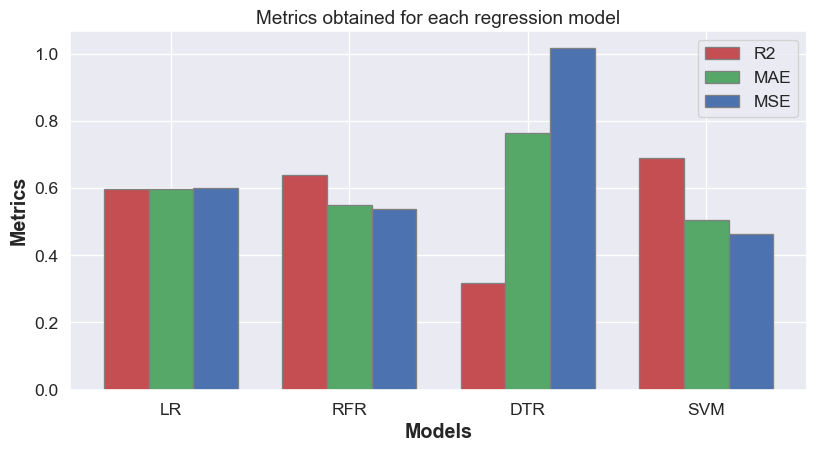

In [21]:
reg_models_comparison(X_train, X_train_norm, y_train, X_val, X_val_norm, y_val)

By making use of RandomizedSearchCV() we are able to find the RF model that better performs with the given training data. This may help us in our quest for finding the best features.

In [ ]:
from random import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

params = {'max_depth': [3,6,9, None], 'n_estimators': [50, 100, 150, 300, 500, 1000], 'max_features': [50,75, 100, len(X.columns)],
          'criterion': ['gini', 'entropy', 'mae'], 'bootstrap':[True, False]}

rnd_search = RandomizedSearchCV(RandomForestRegressor(), params, cv = 5)
rnd_search.fit(X_train, y_train)

In [ ]:
# Score and parameters of the model with the best performance 
print(rnd_search.best_score_)
print(rnd_search.best_params_)
rf_lipo_baseline = rnd_search.best_estimator_

In [ ]:
#We predict the output values for the validation set 
y_pred = rf_lipo_baseline.predict(X_val)
plot_regression_metrics(y_val, y_pred, 0)

## Data visualization

In [ ]:
#We now count the number of Zeros in each column

threshold = 3500
#Columns that contain zero values
desc_name = df.columns[(df == 0).sum(axis=0) > 0]
desc_count = (df[df.columns[(df == 0).sum(axis=0) > 0]] == 0).sum(axis=0)

color = ['red' if i > threshold else 'black' for i in desc_count]
size = [80 if i > threshold else 30 for i in desc_count]

# Scatter plot
fig, ax = plt.subplots();
ax.scatter(np.arange(len(desc_name)), desc_count, c=color, s=size)
plt.title('Number of zeros contained in the DF for each descriptor')
plt.xlabel('Descriptor index')
plt.ylabel('Zero values count')
fig.set_size_inches(20, 10);

for i in np.arange(len(desc_name)):
    ax.annotate(i, (i, desc_count[i]), rotation=15)
    
plt.show()

In [ ]:
# Visualize data distribution in traning and validation datasets

fig, ax = plt.subplots(figsize=(10,5))

for ind, a in enumerate([y_train, y_val]):
    if ind == 0:
        sns.distplot(a, ax=ax, label = 'Training')
    else:
        sns.distplot(a, ax=ax, label = 'Validation')

plt.xlabel('Y values')
plt.title('Distribution of target values in training and validation sets') 
plt.legend(loc = 'best')
plt.show()

In [ ]:
explainer = shap.TreeExplainer(rf_lipo_baseline)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type = 'bar')

##### Descriptors with a highest impact in prediction:
- MolLogP : Values that describes how the drug diffuses through the membrane. It needs to have the right balance of water and lipid solubility 

In [ ]:
shap.summary_plot(shap_values, X_val)

## Improving the model 

### Data cleaning

##### Pipeline
- Remove **MolLogP** and **BCUT2D** features. 
- Remove **zero variance features**. 
- Remove **high correlated** features. 
- **Normalizing** when using linear models.
- Feature selection (MRMR, Relief...)

#### 1 - Remove MolLogP, BCUT2D, and zero variance features. 

In [45]:
#Remove MolLogP, BCUT2D, and features with zero variance
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()

selector.fit(X_train)

# Selector.get_support() returns a [,num_descriptors] boolean mask. False represents zero variance columns.
zero_var_cols = [column for column in X_train.columns
                    if column not in X_train.columns[selector.get_support()]]

print('There are {} columns with zero variance'.format(len(zero_var_cols)))

# As BCUT features and MolLogP may have counterproductive effects, we proceed to delete them
zero_var_cols.extend([col for col in df.columns if 'BCUT2D' in col or 'MolLogP' in col])

# We drop this first set of 11 columns in each set. 
X_train.drop(zero_var_cols, axis = 1, inplace = True)
X_val.drop(zero_var_cols, axis = 1, inplace = True)
X_test.drop(zero_var_cols, axis = 1, inplace = True)

There are 10 columns with zero variance


#### 2 - Remove high correlated features

In [39]:
# We drop the features with a high correlation (We do not consider columns that were already given by the dataset)

corr = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than X
correlated_features = [col for col in upper.columns if any(upper[col] > 0.9)]

print('Number of correlated features deleted: {}'.format(len(correlated_features)))

X_train.drop(correlated_features, axis = 1, inplace = True)
X_val.drop(correlated_features, axis = 1, inplace = True)
X_test.drop(correlated_features, axis = 1, inplace = True)

Number of correlated features deleted: 42


In [46]:
print('Total number of remaining descriptors after the data cleaning: {}'.format(X_train.shape[1]))

Total number of remaining descriptors after the data cleaning: 188


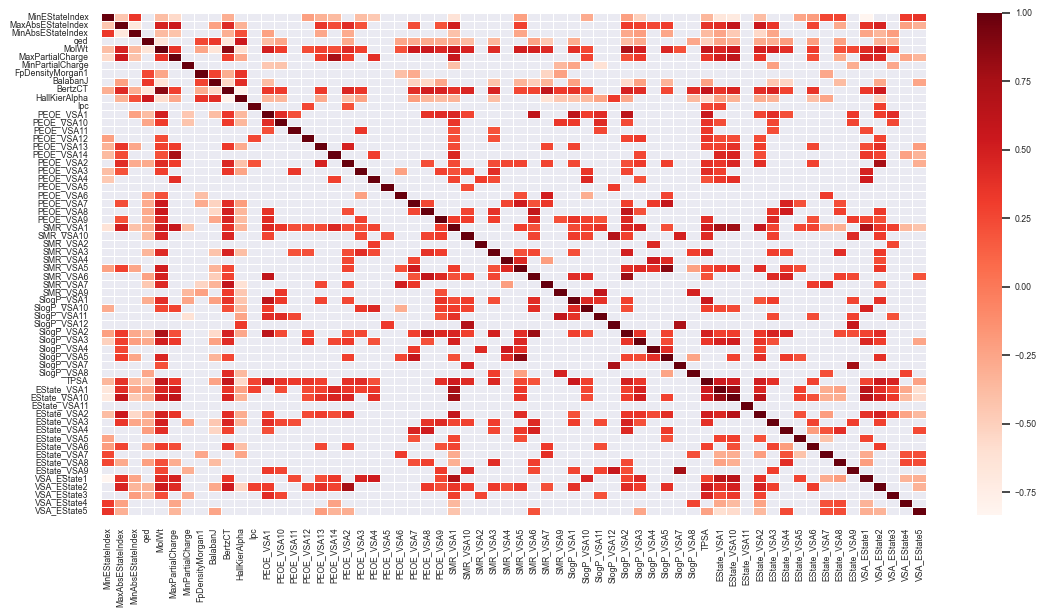

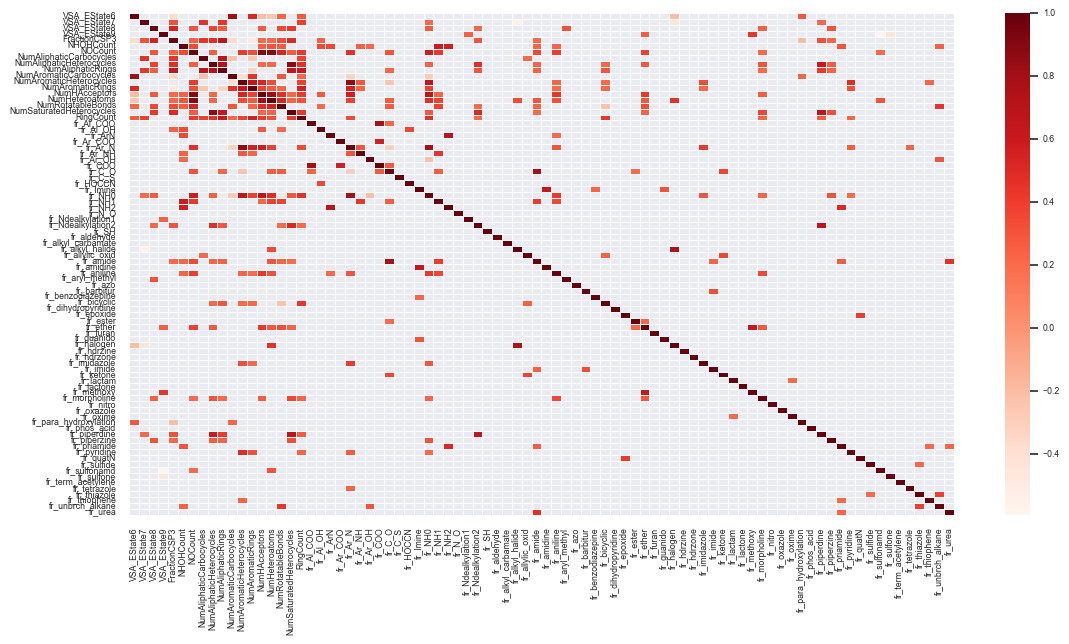

In [33]:
# Changes the tick font size 
sns.set(font_scale = 0.6)

for i in range(2):
    plt.figure(figsize=(14, 7), dpi = 95)
    if i==0:
        corr = X_train[X_train.columns[:62]].corr()
        sns.heatmap(corr[corr.abs() >= .2], cmap="Reds", linewidths=.5,
                    xticklabels=True, yticklabels=True)
    else:
        corr = X_train[X_train.columns[62:]].corr()
        sns.heatmap(corr[corr.abs() >= .2], cmap="Reds", linewidths=.5,
                    xticklabels=True, yticklabels=True)
    plt.show()

#### 3 - Normalize data to use in linear models

In [47]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

#### Models comparison after data cleaning

LR | R2: 0.600, MAE: 0.591, MSE: 0.595
RFR | R2: 0.596, MAE: 0.582, MSE: 0.601
DTR | R2: 0.207, MAE: 0.787, MSE: 1.181
SVM | R2: 0.683, MAE: 0.506, MSE: 0.472


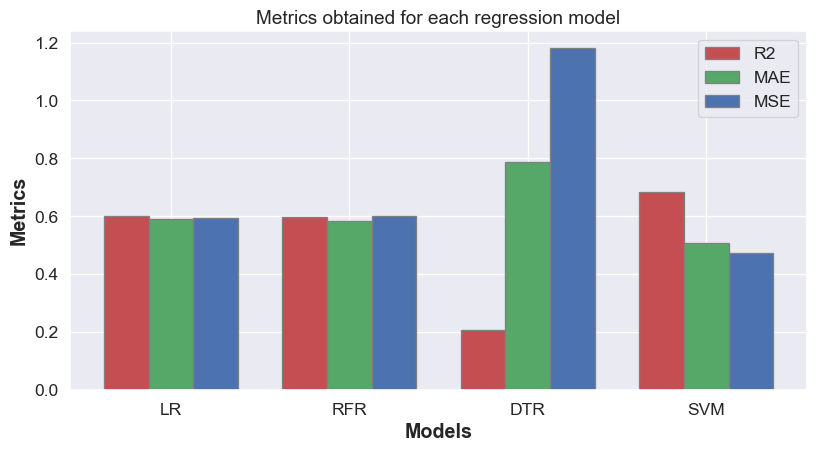

In [48]:
reg_models_comparison(X_train, X_train_norm, y_train, X_val, X_val_norm, y_val)

## Ames mutagenicity 
Mutagenicity means the ability of a drug to induce genetic alterations. Drugs that can cause damage to the DNA can result in cell death or other severe adverse effects

In [ ]:
from tdc.single_pred import Tox
data = Tox(name = 'AMES')
split_AMES = data.get_split()

In [ ]:
split_AMES['train']